In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# LIBRBARIES:

In [ ]:
import numpy as np
import pandas as pd

from PIL import Image
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('seaborn-whitegrid')

from progressbar import ProgressBar

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# PATHS:

In [ ]:
data_path = 'gdrive/My Drive/1_PROJECTS/2_APPAREL_RECOMMENDATION/DATA/'
img_path = data_path + '16k_images/'

# DATA:

In [ ]:
arryO_valid_idxs = np.load(data_path + 'arryO_valid_idxs.npy')

In [ ]:
df = pd.read_csv(data_path + 'df_text_vectorize.csv')
df.head()

,img,text
0,B016I2TS4W.jpeg,women superheroes for ironman round neck sleev...
1,B01N49AI08.jpeg,fig womens izo clothing shirt tunic
2,B01JDPCOHO.jpeg,fig top womens clothing won shirt
3,B01N19U5H5.jpeg,sailor women girl top collar harajuku focal18 ...
4,B004GSI2OS.jpeg,stone onyx black featherlite twill resistant s...


In [ ]:
df_imgs = df.iloc[arryO_valid_idxs]
df_imgs.shape

(11879, 2)

# TFIDF VECTORIZERIZATION:

In [ ]:
corpus = df.text.values

%time TFIDF_vectorizer = TfidfVectorizer(min_df=1).fit(corpus)
%time tfidf_matrix = TFIDF_vectorizer.transform(corpus)

CPU times: user 2.09 s, sys: 8.5 ms, total: 2.1 s
Wall time: 2.13 s
CPU times: user 2.12 s, sys: 6.19 ms, total: 2.13 s
Wall time: 2.14 s


In [ ]:
tfidf_features = TFIDF_vectorizer.get_feature_names()
len(tfidf_features)

43019

# PRETRAINED W2V MODEL_DICT:

In [ ]:
with open(data_path + 'word2vec_model', 'rb') as handle:
    w2v_model = pickle.load(handle)  #-----------------------------------Dict of {word:vector}

In [ ]:
len(w2v_model)

46603

In [ ]:
len(set(w2v_model.keys()))

46603

# FN FOR COMPUTING AVERAGE W2V DOC VECS:

In [ ]:
def retrn_w2v_sentence_vecs(tfidf_matrix, tfidf_features, w2v_model):

    pbar = ProgressBar(max_value = tfidf_matrix[arryO_valid_idxs].shape[0])
    listO_word2vec_sentence_vec = []

    for tfidf_row in pbar(tfidf_matrix[arryO_valid_idxs]):

        non_zero_idxs = tfidf_row.toarray().squeeze().nonzero()[0]
        tfidf_row = tfidf_row.toarray().squeeze()[non_zero_idxs]
        sent_words = np.array(tfidf_features)[non_zero_idxs]

        word_vec_row = [w2v_model.get(word, np.zeros(300)) for word in sent_words]
        word2vec_sentence_vec = sum(word_vec_row)/len(word_vec_row)

        listO_word2vec_sentence_vec.append(word2vec_sentence_vec)
        arryO_word2vec_sentence_vec = np.array(listO_word2vec_sentence_vec)

        pbar.update()

    return arryO_word2vec_sentence_vec

# CREATING AVERAGE W2V DOC VECTORS:

In [ ]:
arryO_word2vec_sentence_vec = retrn_w2v_sentence_vecs(tfidf_matrix, tfidf_features, w2v_model)

arryO_word2vec_sentence_vec.shape

100% (11879 of 11879) |##################| Elapsed Time: 0:02:41 Time:  0:02:41


(11879, 300)

In [ ]:
np.save(data_path + 'arryO_word2vec_sentence_vec.npy', arryO_word2vec_sentence_vec)

In [ ]:
dim_reduced_bow_matrix = np.load(data_path + 'dim_reduced_bow_matrix.npy')
arryO_word2vec_sentence_vec = np.load(data_path + 'arryO_word2vec_sentence_vec.npy')

# FN FOR PLOTTING IMAGES:

In [ ]:
def fn_show_imgs(query_idx, listO_imgs_bow, listO_imgs_tfidf, figsize):

    print()
    print('QUERY:')
    query_img  = df.img.values[query_idx]
    display(Image.open(img_path + query_img).resize((170, 170)))
    print()

    listO_valid_imgs = []
    listO = [listO_imgs_bow, listO_imgs_tfidf]

    for l in listO:
        n = 1
        for img in l:
            try:
                Image.open(img_path + img).resize((150, 150))
                listO_valid_imgs.append(img)
                n+=1
                if n > 6:
                    break
            except:
                pass

    imgs = [Image.open(img_path + img) for img in listO_valid_imgs]
    fig, axes = plt.subplots(2, 6, figsize=figsize)
    axes = axes.ravel()

    for idx, img in enumerate(imgs):
        if idx == 0:  axes[idx].set(title = 'BOW BASED RECOMMENDATIONS:')
        if idx == 6:  axes[idx].set(title = 'TFIDF BASED RECOMMENDATIONS:')
        axes[idx].imshow(img, aspect='auto')

    plt.tight_layout()

# FN FOR SIMILARITY:

In [ ]:
def fn_similar_vecs(query_idx, df_imgs, matrixO_vecs, buffer = 1000, n_recommendations = 6):

    query_img  = df_imgs.img.values[query_idx]

    listO_losses = []
    for idx in range(len(matrixO_vecs)):

        loss = (((matrixO_vecs[query_idx] - matrixO_vecs[idx])**2).sum())**(1/2) #-----EUCLEDIAN DIST
        listO_losses.append(loss)

    arryO_losses = np.array(listO_losses)

    best_idxs = np.argsort(arryO_losses)[1:n_recommendations+buffer]

    listO_most_simi_imgs = df_imgs.iloc[best_idxs].img.values

    return listO_most_simi_imgs

# RECOMMENDATIONS:


QUERY:


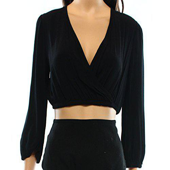

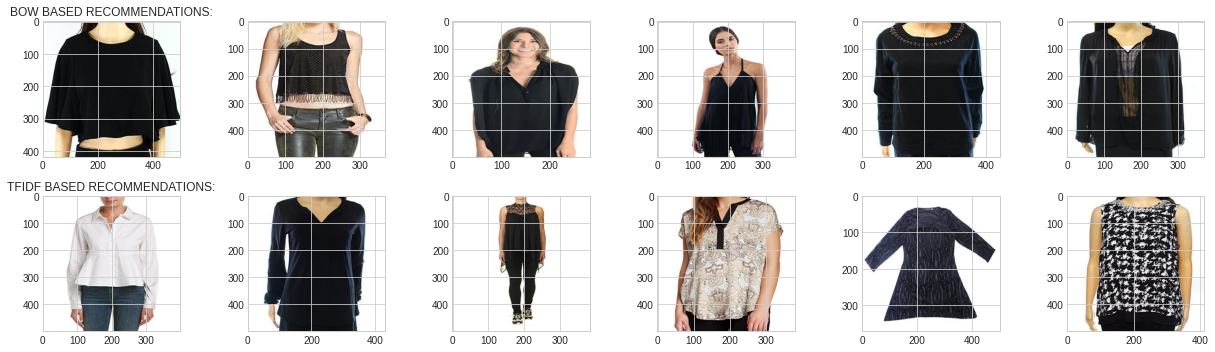

In [ ]:
query_idx = 227
df = df_imgs
listO_imgs_bow = fn_similar_vecs(query_idx, df, dim_reduced_bow_matrix[arryO_valid_idxs])
listO_imgs_tfidf = fn_similar_vecs(query_idx, df, arryO_word2vec_sentence_vec)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_bow, listO_imgs_tfidf, figsize)


QUERY:


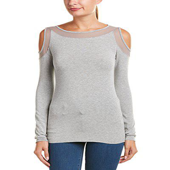

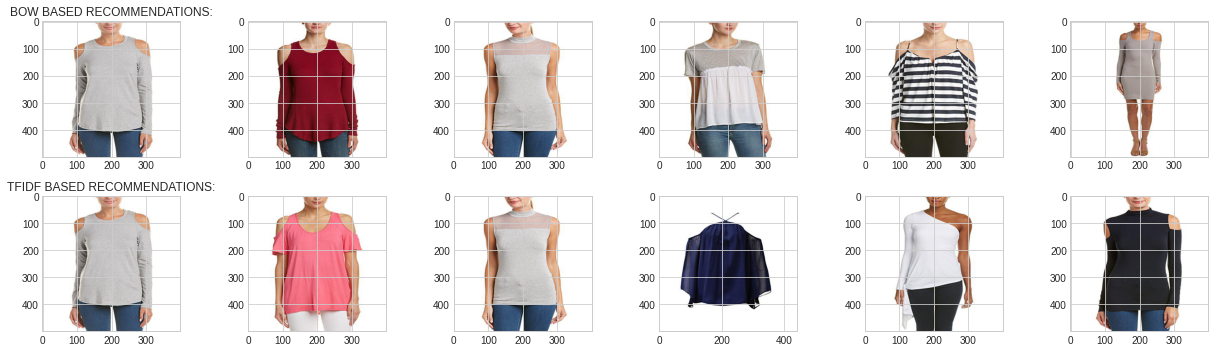

In [ ]:
query_idx = 54
df = df_imgs
listO_imgs_bow = fn_similar_vecs(query_idx, df, dim_reduced_bow_matrix[arryO_valid_idxs])
listO_imgs_tfidf = fn_similar_vecs(query_idx, df, arryO_word2vec_sentence_vec)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_bow, listO_imgs_tfidf, figsize)


QUERY:


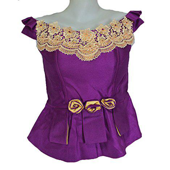

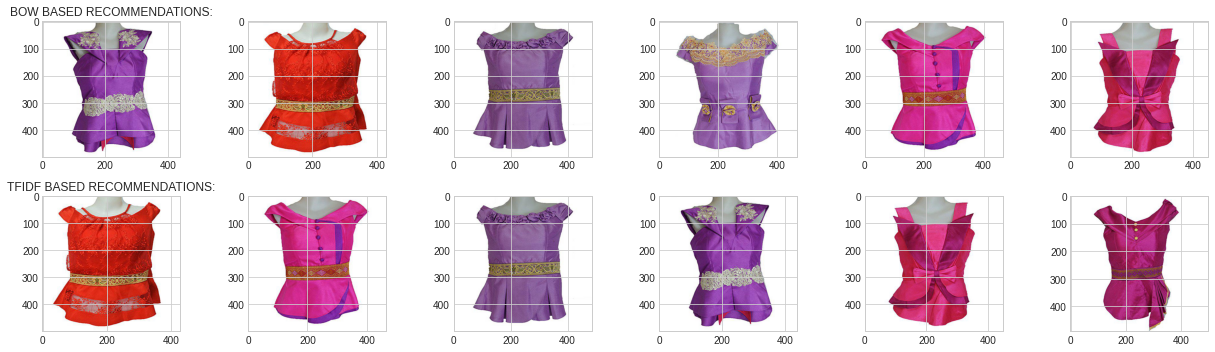

In [ ]:
query_idx = 28
df = df_imgs
listO_imgs_bow = fn_similar_vecs(query_idx, df, dim_reduced_bow_matrix[arryO_valid_idxs])
listO_imgs_tfidf = fn_similar_vecs(query_idx, df, arryO_word2vec_sentence_vec)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_bow, listO_imgs_tfidf, figsize)


QUERY:


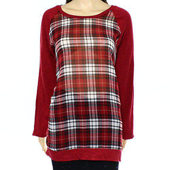

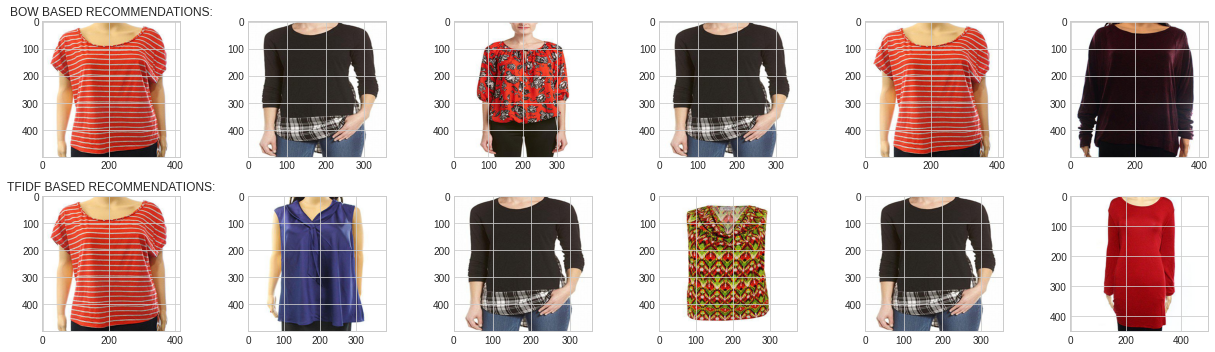

In [ ]:
query_idx = 557
df = df_imgs
listO_imgs_bow = fn_similar_vecs(query_idx, df, dim_reduced_bow_matrix[arryO_valid_idxs])
listO_imgs_tfidf = fn_similar_vecs(query_idx, df, arryO_word2vec_sentence_vec)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_bow, listO_imgs_tfidf, figsize)


QUERY:


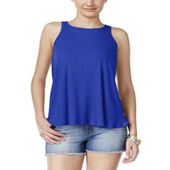

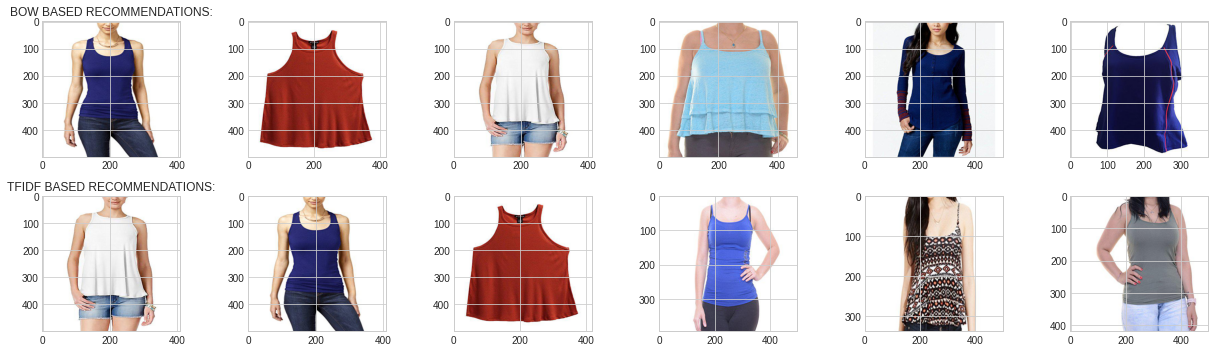

In [ ]:
query_idx = 477
df = df_imgs
listO_imgs_bow = fn_similar_vecs(query_idx, df, dim_reduced_bow_matrix[arryO_valid_idxs])
listO_imgs_tfidf = fn_similar_vecs(query_idx, df, arryO_word2vec_sentence_vec)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_bow, listO_imgs_tfidf, figsize)


QUERY:


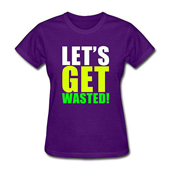

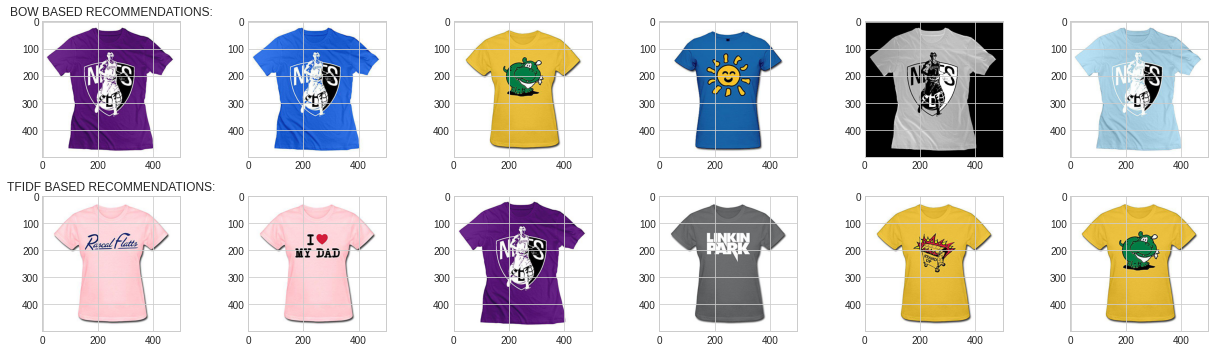

In [ ]:
query_idx = 10222
df = df_imgs
listO_imgs_bow = fn_similar_vecs(query_idx, df, dim_reduced_bow_matrix[arryO_valid_idxs])
listO_imgs_tfidf = fn_similar_vecs(query_idx, df, arryO_word2vec_sentence_vec)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_bow, listO_imgs_tfidf, figsize)